In [61]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import geopandas as gpd
import numpy as np
from sklearn.metrics import r2_score, root_mean_squared_error

In [89]:
pred_true = pd.read_csv("best_df.csv")

print("Mean yield in great plains from 2018-2020 is:", np.round(pred_true["y_true"].mean(), 2), "t/ha")
print("R2 score for validation years 2018-2020 is:", np.round(r2_score(pred_true["y_true"], pred_true["y_pred"]), 2))
print("This R2 score is calculated using mean yield from great plains only")

Mean yield in great plains from 2018-2020 is: 2.77 t/ha
R2 score for validation years 2018-2020 is: 0.6
This R2 score is calculated using mean yield from great plains only


In [90]:
yield_df = pd.read_csv('data/CY-Bench/US/wheat/yield_wheat_US.csv')
us_wheat_mean = yield_df.loc[yield_df['harvest_year'].isin([2018, 2019, 2020]), "yield"].mean()

print("Mean yield across whole US from 2018-2020 is:", np.round(us_wheat_mean, 2), "t/ha")

Mean yield across whole US from 2018-2020 is: 3.85 t/ha


In [91]:
numerator = sum((pred_true["y_true"] - pred_true["y_pred"])**2)
denominator = sum((pred_true["y_true"] - us_wheat_mean)**2)
r2_score_scratch = 1 - (numerator / denominator)

print("R2 score with national mean yield:", np.round(r2_score_scratch, 2))

R2 score with national mean yield: 0.83


#### The same applies for NRMSE

In [92]:
root_mean_squared_error(pred_true["y_true"], pred_true["y_pred"])

0.5719654159642704

In [93]:
print(np.round(root_mean_squared_error(pred_true["y_true"], pred_true["y_pred"]) / np.mean(pred_true["y_true"]),2))
print(np.round(root_mean_squared_error(pred_true["y_true"], pred_true["y_pred"]) / us_wheat_mean, 2))

0.21
0.15


### Read shapefile

In [94]:
us_shape = gpd.read_file("data/shapefiles/US/tl_2023_us_county/tl_2023_us_county.shp")

In [95]:
pred_true = pred_true.assign(se=(pred_true["y_true"] - pred_true["y_pred"])**2)

In [96]:
pred_true = pred_true.groupby("adm_id").agg({"se": "mean", "y_true":"mean"}).reset_index()

In [97]:
pred_true = pred_true.merge(us_shape.assign(adm_id="US-"+us_shape["STATEFP"]+"-"+us_shape["COUNTYFP"])[["adm_id", "geometry"]], on="adm_id", how="left")

In [98]:
pred_true = gpd.GeoDataFrame(pred_true, geometry="geometry")

In [99]:
us_states = us_shape.loc[us_shape["STATEFP"].isin(['08', '20', '31', '40', '46', '48'])].dissolve(by="STATEFP")

<Axes: >

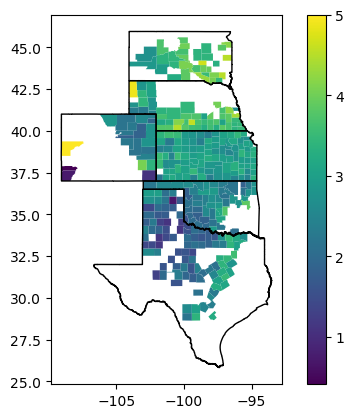

In [100]:
us_states.plot(facecolor="none", edgecolor="black", linewidth=1, ax=pred_true.plot(column="y_true", legend=True, cmap="viridis", vmax=5))

In [33]:
yield_df = (yield_df.assign(state=yield_df["adm_id"].str.split("-").str[1])
                    .drop(["crop_name", "country_code", "harvest_area", "production"], axis=1))

yield_df = yield_df.loc[(yield_df["harvest_year"].between(2004, 2023)) & (yield_df["state"].isin(['08', '20', '31', '40', '46', '48']))].reset_index(drop=True)

In [36]:
yield_df = yield_df.assign(split=yield_df["harvest_year"].apply(lambda x: "train" if (x >= 2004 and x <= 2017) else "val" if (x >= 2018 and x <= 2020) else "test"))

In [45]:
great_plains = {'08': 'Colorado', '20': 'Kansas', '31': 'Nebraska', '40': 'Oklahoma', '46': 'South Dakota', '48': 'Texas'}

<Axes: xlabel='split', ylabel='yield'>

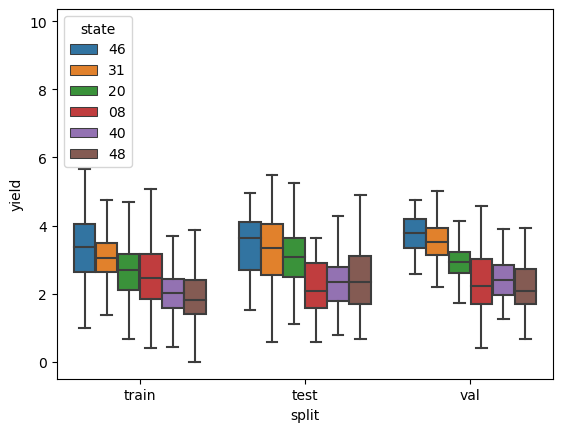

In [47]:
sns.boxplot(data=yield_df, x="split", y="yield", hue="state", fliersize=0, hue_order=['46', '31', '20', '08', '40', '48'])

In [49]:
yield_df.sort_values(by="yield")

,adm_id,harvest_year,yield,state,split
3018,US-48-235,2009,0.00000,48,train
3022,US-48-127,2009,0.00000,48,train
3019,US-48-435,2009,0.00000,48,train
3021,US-48-175,2009,0.00000,48,train
3020,US-48-055,2009,0.00000,48,train
...,...,...,...,...,...
3202,US-08-077,2017,8.62113,08,train
3204,US-08-077,2014,8.81630,08,train
3205,US-08-077,2012,8.84995,08,train
3206,US-08-077,2011,8.86341,08,train
